In [1]:
import torch
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from easydict import EasyDict as edict
from skimage import io
import numpy as np
import json


from src.models.rn_25D_wMLPref import RN_25D_wMLPref

/home/nikkelitous/anaconda3/envs/awr/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [12]:
image=io.imread("https://source.unsplash.com/QyCH5jwrD_A") #photo by Kira auf der Heide

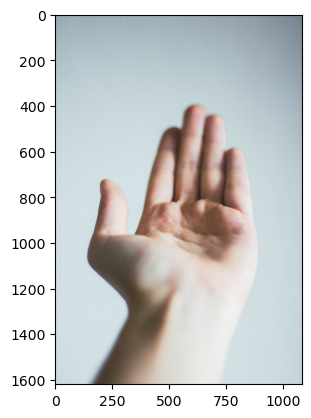

In [13]:
#If you want to see the image that was just loaded, run this cell but it's optional
plt.imshow(image)

In [14]:
image_mean = np.array([0.485, 0.456, 0.406])
image_std = np.array([0.229, 0.224, 0.225])

In [15]:
model_path = 'data/models/rn50_peclr_yt3d-fh_pt_fh_ft.pth'
model_type = "rn50"
model = RN_25D_wMLPref(backend_model=model_type)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model.cuda()

RN_25D_wMLPref(
  (backend_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [16]:
img = image.astype(np.float32) / 255
img = np.divide((img - image_mean), image_std)
img = cv2.resize(img, (224,224))
img = torch.from_numpy(img.transpose(2, 0, 1))
img = img.unsqueeze(0).float().cuda()

In [17]:
with torch.no_grad():
    output = model(img, None)
kp2d = output["kp25d"][:, :21, :2][0]
height, width = image.shape[:2]
kp2d[:,0] *= width / 224
kp2d[:,1] *= height / 224

In [18]:
print(kp2d) # This is the coordinates of each finger position.

tensor([[ 529.3111, 1202.3544],
        [ 669.6180, 1229.8276],
        [ 652.3438, 1055.8578],
        [ 539.5645,  999.1763],
        [ 421.9455,  991.9676],
        [ 338.4621,  976.4766],
        [ 774.8398, 1117.7196],
        [ 675.6631,  844.2829],
        [ 562.1689,  793.2574],
        [ 468.4601,  820.2117],
        [ 325.2811,  873.7744],
        [ 805.3339,  944.4954],
        [ 683.1323,  712.0454],
        [ 586.8162,  663.7953],
        [ 510.6802,  694.0242],
        [ 327.3896,  790.9953],
        [ 815.9247,  659.1335],
        [ 687.5983,  629.0141],
        [ 625.4288,  575.4359],
        [ 561.8920,  616.8156],
        [ 347.8039,  729.8989]], device='cuda:0')


If you want to view a visualization of the hands with their landmarks you can run the following cells, but they're optional and not necessary to use the landmarks for alignment.

In [19]:
# All these functions came directly from PeCLR code
# but are copied here instead of imported to avoid needing to define system variables
from typing import NewType, Tuple

def read_json(file_path: str) -> dict:
    """Reads json file from the given path.

    Args:
        file_path (str): Location of the file

    Returns:
        dict: Json content formatted as python dictionary in most cases
    """
    with open(file_path, "r") as f:
        return json.load(f)

def plot_hand(
    axis: plt.Axes,
    coords_hand: np.array,
    plot_3d: bool = False,
    linewidth: str = "1",
    linestyle: str = "-",
    alpha: float = 1.0,
    ms=1,
):
    """Makes a hand stick figure from the coordinates wither in uv plane or xyz plane on the passed axes object.
    Code adapted from:  https://github.com/lmb-freiburg/freihand/blob/master/utils/eval_util.py

    Args:
        axis (plt.Axes): Matlplotlib axes, for 3D plots pass axes with 3D projection
        coords_hand (np.array): 21 coordinates of hand as numpy array. (21 x 3). Expects AIT format.
        plot_3d (bool, optional): Pass this as true for using the the depth parameter to plot the hand. Defaults to False.
        linewidth (str, optional): Linewidth to be used for drawing connecting bones. Defaults to "1".
        linestyle (str, optional): MAtplotlib linestyle, Defaults to ":"
    """

    colors = np.array(
        read_json(
            os.path.join("./", "src", "visualization", "joint_color.json")
        )["joint_color2"]
    )
    coords_hand = joints.ait_to_freihand(coords_hand)
    # define connections and colors of the bones
    bones = [
        ((i, i + 1), colors[1 + i, :]) if i % 4 != 0 else ((0, i + 1), colors[1 + i, :])
        for i in range(0, 20)
    ]
    # Making connection between the joints.
    for connection, color in bones:
        coord1 = coords_hand[connection[0], :]
        coord2 = coords_hand[connection[1], :]
        coords = np.stack([coord1, coord2])
        if plot_3d:
            axis.plot(
                coords[:, 0],
                coords[:, 1],
                coords[:, 2],
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                alpha=alpha,
            )
        else:
            axis.plot(
                coords[:, 0],
                coords[:, 1],
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                alpha=alpha,
            )

    # Highlighting the joints
    for i in range(21):
        if plot_3d:
            axis.plot(
                coords_hand[i, 0],
                coords_hand[i, 1],
                coords_hand[i, 2],
                "o",
                color=colors[i, :],
            )
        else:
            axis.plot(
                coords_hand[i, 0],
                coords_hand[i, 1],
                "o",
                color=colors[i, :],
                linestyle=linestyle,
                alpha=alpha,
                ms=ms,
            )

#  Standard types to be used in the codebase.
JOINTS_25D = NewType(
    (
        "Hand coordinates of shape 21 x 3, where first two columns are x and y"
        "in image plane and third columnis scaled relative depth."
    ),
    torch.Tensor,
)
SCALE = NewType("scale, distance between the root and index mcp", torch.Tensor)
JOINTS_3D = NewType("Hand coordinates of shape 21 x 3", torch.Tensor)
CAMERA_PARAM = NewType("Camera params of dim 2 x 3", torch.Tensor)


class Joints:
    def __init__(self):
        self.mapping = edict(
            read_json(
                os.path.join(
                    "./", "src", "data_loader", "joint_mapping.json"
                )
            )
        )
        self.freihand_ait_index_map = self.get_set1_to_set2_index_map(
            set1="ait", set2="freihand"
        )
        self.interhand_ait_index_map = self.get_set1_to_set2_index_map(
            set1="ait", set2="interhand"
        )
        self.mano_ait_index_map = self.get_set1_to_set2_index_map(
            set1="ait", set2="mano"
        )
        self.ait_freihand_index_map = self.get_set1_to_set2_index_map(
            set1="freihand", set2="ait"
        )
        self.ait_interhand_index_map = self.get_set1_to_set2_index_map(
            set1="interhand", set2="ait"
        )
        self.ait_mano_index_map = self.get_set1_to_set2_index_map(
            set1="mano", set2="ait"
        )

    def get_set1_to_set2_index_map(
        self, set1: str = "freihand", set2: str = "ait"
    ) -> np.array:
        index_map = []
        for i in self.mapping.ait.keys():
            index_map.append([self.mapping[set1][i], self.mapping[set2][i]])
        return np.array(sorted(index_map, key=lambda x: x[0]))

    def freihand_to_ait(self, joints_3D: JOINTS_3D) -> JOINTS_3D:
        return joints_3D[self.freihand_ait_index_map[:, 1]]

    def ait_to_freihand(self, joints_3D: JOINTS_3D) -> JOINTS_3D:
        return joints_3D[self.ait_freihand_index_map[:, 1]]

    def interhand_to_ait(self, joints_3D: JOINTS_3D) -> JOINTS_3D:
        return joints_3D[self.interhand_ait_index_map[:, 1]]

    def mano_to_ait(self, joints_3D: JOINTS_3D) -> JOINTS_3D:
        return joints_3D[self.mano_ait_index_map[:, 1]]

joints=Joints()

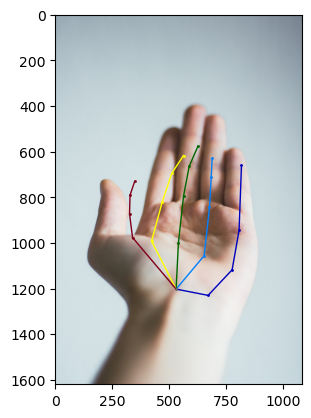

In [20]:
plt.imshow(image)
plot_hand(plt, kp2d.cpu())